In [13]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import os, glob, shutil, math, time
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import History, CSVLogger, EarlyStopping
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


########################################################################
# This section rescales the data. For most ML models, we want to       #
# rescale so that we are analyzing data consistently (scale invariant) #
########################################################################
def data_rescale(scaled_dat,train_mean,train_var):
    d = np.shape(train_mean)[0]
    dat = (np.multiply(scaled_dat,np.sqrt(train_var))) + train_mean.T
    return(dat)
############################################################################
# Opposite to the above, normalizes the data based on some training values #
############################################################################
def data_normalize(data,train_mean,train_var):
    d = np.shape(train_mean)[0]
    print('normalizing with number of dimensions = ' +str(d))
    scaled_dat = np.divide((data - train_mean.T),np.sqrt(train_var),)
    return(scaled_dat)
    


In [14]:
data = pd.read_csv("../Data/QM9/mu-qm-file.csv")

In [15]:
## seed 
np.random.seed(4)
# get random partition
msk = np.random.rand(np.shape(data)[0]) < 0.20 

# test and train split
first_train_data = data[msk]
test_data = data[~msk]

# train and val split
val_msk = np.random.rand(np.shape(first_train_data)[0]) < 0.80
train_data = first_train_data[val_msk]
val_data = first_train_data[~val_msk]

In [16]:
# get 
feature_names=[]
for ft in data.columns:
    if ft.find('u0') ==-1  and ft.find('runs') ==-1 and ft.find('mu') ==-1:
            feature_names.append(ft)
print(feature_names)

['f-chi-0-all', 'f-chi-1-all', 'f-chi-2-all', 'f-chi-3-all', 'f-Z-0-all', 'f-Z-1-all', 'f-Z-2-all', 'f-Z-3-all', 'f-I-0-all', 'f-I-1-all', 'f-I-2-all', 'f-I-3-all', 'f-T-0-all', 'f-T-1-all', 'f-T-2-all', 'f-T-3-all', 'f-S-0-all', 'f-S-1-all', 'f-S-2-all', 'f-S-3-all']


In [17]:
variable = 'u0'
H_to_kcal_mol = 627.5095
train_data_y = train_data[variable]*H_to_kcal_mol
test_data_y = test_data[variable]*H_to_kcal_mol
val_data_y = val_data[variable]*H_to_kcal_mol
# xvales
train_data_x = train_data[feature_names].values
test_data_x = test_data[feature_names].values
val_data_x = val_data[feature_names].values
## data generation
m = np.shape(train_data_x)[0]
d = np.shape(train_data_x)[1]
p = 1
# normalization
train_var_x = np.var(train_data_x,0)
train_mean_x = np.mean(train_data_x,0).reshape(d,1).squeeze()
train_var_y = np.var(train_data_y,0).reshape(1)
train_mean_y = np.mean(train_data_y,0).reshape(1)
# scale
scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y)
scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)
scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y)
scaled_val_data_x = data_normalize(val_data_x,train_mean_x,train_var_x)
scaled_val_data_y = data_normalize(val_data_y,train_mean_y,train_var_y)

normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1


In [22]:
def prepare_architecture(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=["mae"])
    return model

def train_model(model, x_train, y_train, x_val, y_val,epochs, verbose=True):
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=100, verbose=1, mode='auto')
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=50, validation_data=(x_val, y_val),
            callbacks=[earlystop], verbose=verbose)
    return model, history

In [25]:
layers = [Dense(300, input_dim=20, kernel_initializer='normal', activation='relu',kernel_regularizer = l2(1e-06)),
          Dropout(0.10, noise_shape=None, seed=None),
          Dense(300, kernel_initializer='normal', activation='relu', kernel_regularizer = l2(1e-06)),
          Dropout(0.10, noise_shape=None, seed=None), 
          Dense(1,activation='linear')]
model = prepare_architecture(layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 300)               6300      
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 301       
Total params: 96,901
Trainable params: 96,901
Non-trainable params: 0
_________________________________________________________________
None


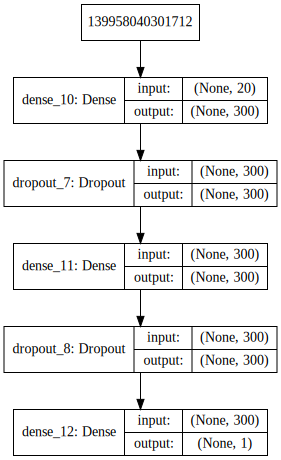

In [26]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [27]:
trained_model, history = train_model(model,scaled_train_data_x,scaled_train_data_y,
                                            scaled_val_data_x,scaled_val_data_y,2000)

Train on 21677 samples, validate on 5375 samples
Epoch 1/2000
21677/21677 [==============================] - 6s 281us/step - loss: 0.0254 - mean_absolute_error: 0.1045 - val_loss: 0.0120 - val_mean_absolute_error: 0.0783
Epoch 2/2000
21677/21677 [==============================] - 4s 167us/step - loss: 0.0117 - mean_absolute_error: 0.0797 - val_loss: 0.0061 - val_mean_absolute_error: 0.0567
Epoch 3/2000
21677/21677 [==============================] - 4s 191us/step - loss: 0.0101 - mean_absolute_error: 0.0742 - val_loss: 0.0060 - val_mean_absolute_error: 0.0572
Epoch 4/2000
21677/21677 [==============================] - 4s 171us/step - loss: 0.0098 - mean_absolute_error: 0.0721 - val_loss: 0.0059 - val_mean_absolute_error: 0.0550
Epoch 5/2000
21677/21677 [==============================] - 4s 164us/step - loss: 0.0101 - mean_absolute_error: 0.0712 - val_loss: 0.0074 - val_mean_absolute_error: 0.0678
Epoch 6/2000
21677/21677 [==============================] - 4s 186us/step - loss: 0.0082 - 

21677/21677 [==============================] - 4s 169us/step - loss: 0.0057 - mean_absolute_error: 0.0542 - val_loss: 0.0043 - val_mean_absolute_error: 0.0490
Epoch 49/2000
21677/21677 [==============================] - 4s 176us/step - loss: 0.0057 - mean_absolute_error: 0.0534 - val_loss: 0.0039 - val_mean_absolute_error: 0.0441
Epoch 50/2000
21677/21677 [==============================] - 4s 171us/step - loss: 0.0055 - mean_absolute_error: 0.0531 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419
Epoch 51/2000
21677/21677 [==============================] - 4s 174us/step - loss: 0.0058 - mean_absolute_error: 0.0542 - val_loss: 0.0042 - val_mean_absolute_error: 0.0487
Epoch 52/2000
21677/21677 [==============================] - 4s 164us/step - loss: 0.0053 - mean_absolute_error: 0.0522 - val_loss: 0.0034 - val_mean_absolute_error: 0.0416
Epoch 53/2000
21677/21677 [==============================] - 4s 192us/step - loss: 0.0053 - mean_absolute_error: 0.0523 - val_loss: 0.0040 - val_mean

21677/21677 [==============================] - 4s 168us/step - loss: 0.0052 - mean_absolute_error: 0.0515 - val_loss: 0.0026 - val_mean_absolute_error: 0.0342
Epoch 96/2000
21677/21677 [==============================] - 3s 156us/step - loss: 0.0054 - mean_absolute_error: 0.0522 - val_loss: 0.0031 - val_mean_absolute_error: 0.0390
Epoch 97/2000
21677/21677 [==============================] - 4s 165us/step - loss: 0.0051 - mean_absolute_error: 0.0511 - val_loss: 0.0028 - val_mean_absolute_error: 0.0342
Epoch 98/2000
21677/21677 [==============================] - 4s 177us/step - loss: 0.0056 - mean_absolute_error: 0.0528 - val_loss: 0.0025 - val_mean_absolute_error: 0.0334
Epoch 99/2000
21677/21677 [==============================] - 4s 176us/step - loss: 0.0051 - mean_absolute_error: 0.0513 - val_loss: 0.0036 - val_mean_absolute_error: 0.0443
Epoch 100/2000
21677/21677 [==============================] - 4s 181us/step - loss: 0.0061 - mean_absolute_error: 0.0555 - val_loss: 0.0033 - val_mea

21677/21677 [==============================] - 4s 186us/step - loss: 0.0054 - mean_absolute_error: 0.0523 - val_loss: 0.0029 - val_mean_absolute_error: 0.0364
Epoch 143/2000
21677/21677 [==============================] - 4s 171us/step - loss: 0.0049 - mean_absolute_error: 0.0497 - val_loss: 0.0045 - val_mean_absolute_error: 0.0445
Epoch 144/2000
21677/21677 [==============================] - 4s 166us/step - loss: 0.0052 - mean_absolute_error: 0.0514 - val_loss: 0.0023 - val_mean_absolute_error: 0.0319
Epoch 145/2000
21677/21677 [==============================] - 5s 231us/step - loss: 0.0050 - mean_absolute_error: 0.0508 - val_loss: 0.0055 - val_mean_absolute_error: 0.0502
Epoch 146/2000
21677/21677 [==============================] - 10s 475us/step - loss: 0.0052 - mean_absolute_error: 0.0510 - val_loss: 0.0032 - val_mean_absolute_error: 0.0416
Epoch 147/2000
21677/21677 [==============================] - 6s 280us/step - loss: 0.0052 - mean_absolute_error: 0.0510 - val_loss: 0.0027 - va

21677/21677 [==============================] - 4s 178us/step - loss: 0.0051 - mean_absolute_error: 0.0501 - val_loss: 0.0034 - val_mean_absolute_error: 0.0420
Epoch 190/2000
21677/21677 [==============================] - 4s 173us/step - loss: 0.0051 - mean_absolute_error: 0.0505 - val_loss: 0.0048 - val_mean_absolute_error: 0.0507
Epoch 191/2000
21677/21677 [==============================] - 4s 181us/step - loss: 0.0054 - mean_absolute_error: 0.0518 - val_loss: 0.0041 - val_mean_absolute_error: 0.0473
Epoch 192/2000
21677/21677 [==============================] - 4s 205us/step - loss: 0.0051 - mean_absolute_error: 0.0505 - val_loss: 0.0027 - val_mean_absolute_error: 0.0361
Epoch 193/2000
21677/21677 [==============================] - 4s 165us/step - loss: 0.0054 - mean_absolute_error: 0.0515 - val_loss: 0.0027 - val_mean_absolute_error: 0.0369
Epoch 194/2000
21677/21677 [==============================] - 5s 237us/step - loss: 0.0052 - mean_absolute_error: 0.0506 - val_loss: 0.0025 - val

21677/21677 [==============================] - 4s 171us/step - loss: 0.0050 - mean_absolute_error: 0.0500 - val_loss: 0.0025 - val_mean_absolute_error: 0.0343
Epoch 237/2000
21677/21677 [==============================] - 4s 166us/step - loss: 0.0051 - mean_absolute_error: 0.0504 - val_loss: 0.0090 - val_mean_absolute_error: 0.0674
Epoch 238/2000
21677/21677 [==============================] - 4s 163us/step - loss: 0.0052 - mean_absolute_error: 0.0510 - val_loss: 0.0026 - val_mean_absolute_error: 0.0352
Epoch 239/2000
21677/21677 [==============================] - 3s 152us/step - loss: 0.0046 - mean_absolute_error: 0.0480 - val_loss: 0.0044 - val_mean_absolute_error: 0.0472
Epoch 240/2000
21677/21677 [==============================] - 3s 153us/step - loss: 0.0052 - mean_absolute_error: 0.0506 - val_loss: 0.0024 - val_mean_absolute_error: 0.0332
Epoch 241/2000
21677/21677 [==============================] - 4s 166us/step - loss: 0.0051 - mean_absolute_error: 0.0502 - val_loss: 0.0033 - val

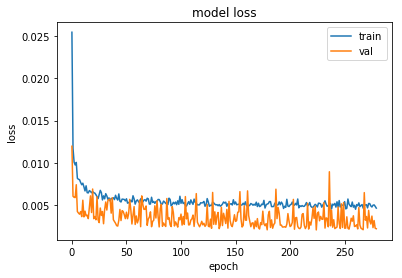

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Text(0,0.5,'pred')

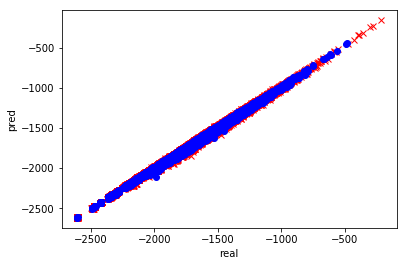

In [29]:
pred_train = data_rescale(model.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
pred_test = data_rescale(model.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
plt.plot(real_test,pred_test,'rx')
plt.plot(real_train,pred_train,'bo')
plt.xlabel('real')
plt.ylabel('pred')